# Beta Regression

This example has been contributed by Tyler James Burch ([\@tjburch](https://github.com/tjburch) on GitHub).

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
from scipy.special import expit

az.style.use("arviz-darkgrid")

In this example, we'll look at using the **Beta distribution** for regression models. The Beta distribution is a probability distribution bounded on the interval [0, 1], which makes it well-suited to model probabilities or proportions. In fact, in much of the Bayesian literature, the Beta distribution is introduced as a prior distribution for the probability $p$ parameter of the Binomial distribution (in fact, it's the conjugate prior for the Binomial distribution).

## Simulated Beta Distribution

To start getting an intuitive sense of the Beta distribution, we'll model coin flipping probabilities. Say we grab all the coins out of our pocket, we might have some fresh from the mint, but we might also have some old ones. Due to the variation, some may be slightly biased toward heads or tails, and our goal is to model distribution of the probabilities of flipping heads for the coins in our pocket.

Since we trust the mint, we'll say the $\alpha$ and $\beta$ are both large, we'll use 1,000 for each, which gives a distribution spanning from 0.45 to 0.55.

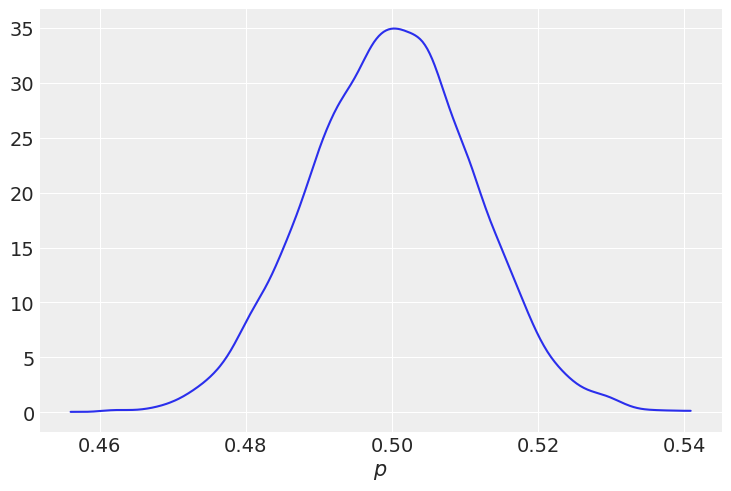

In [2]:
alpha = 1_000
beta = 1_000
p = np.random.beta(alpha, beta, size=10_000)
az.plot_kde(p)
plt.xlabel("$p$");

Next, we'll use Bambi to try to recover the parameters of the Beta distribution. Since we have no predictors, we can do a intercept-only model to try to recover them.

In [3]:
data = pd.DataFrame({"probabilities": p})
model = bmb.Model("probabilities ~ 1", data, family="beta")
fitted = model.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, Intercept]
/home/tomas/oss/bambinos/bambi/.pixi/envs/dev/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
/home/tomas/oss/bambinos/bambi/.pixi/envs/dev/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


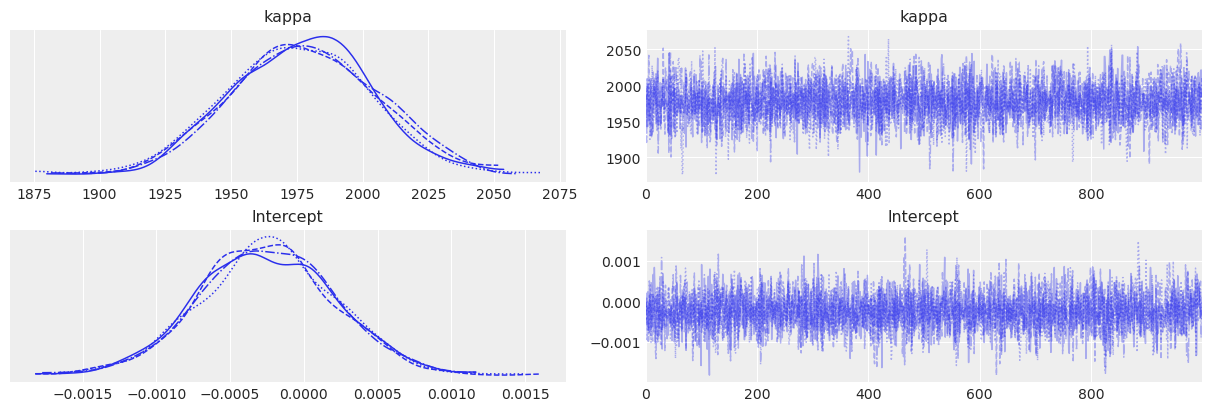

In [4]:
az.plot_trace(fitted);

In [5]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kappa,1976.797,27.418,1926.995,2028.092,0.437,0.448,3954.0,2675.0,1.0
Intercept,-0.000,0.000,-0.001,0.001,0.000,0.000,4345.0,3043.0,1.0


The model fit, but clearly these parameters are not the ones that we used above. For Beta regression, we use a linear model for the mean, so we use the $\mu$ and $\sigma$ formulation. To link the two, we use

$$\alpha = \mu \kappa$$

$$\beta = (1-\mu)\kappa$$

and $\kappa$ is a function of the mean and variance,

$$\kappa = \frac{\mu(1-\mu)}{\sigma^2} - 1$$

Rather than $\sigma$, you'll note Bambi returns $\kappa$. We'll define a function to retrieve our original parameters.

In [6]:
def mukappa_to_alphabeta(mu, kappa):
    # Calculate alpha and beta
    alpha = mu * kappa
    beta = (1 - mu) * kappa

    # Get mean values and 95% HDIs
    alpha_mean = alpha.mean(("chain", "draw")).item()
    alpha_hdi = az.hdi(alpha, hdi_prob=.95)["x"].values
    beta_mean = beta.mean(("chain", "draw")).item()
    beta_hdi = az.hdi(beta, hdi_prob=.95)["x"].values

    return alpha_mean, alpha_hdi, beta_mean, beta_hdi

alpha, alpha_hdi, beta, beta_hdi = mukappa_to_alphabeta(
    expit(fitted.posterior["Intercept"]),
    fitted.posterior["kappa"]
)

print(f"Alpha - mean: {np.round(alpha)}, 95% HDI: {np.round(alpha_hdi[0])} - {np.round(alpha_hdi[1])}")
print(f"Beta - mean: {np.round(beta)}, 95% HDI: {np.round(beta_hdi[0])} - {np.round(beta_hdi[1])}")

Alpha - mean: 988.0, 95% HDI: 962.0 - 1015.0
Beta - mean: 989.0, 95% HDI: 962.0 - 1014.0


We've managed to recover our parameters with an intercept-only model.

## Beta Regression with Predictors

Perhaps we have a little more information on the coins in our pocket. We notice that the coins have accumulated dirt on either side, which would shift the probability of getting a tails or heads. In reality, we would not know how much the dirt affects the probability distribution, we would like to recover that parameter. We'll construct this toy example by saying that each micron of dirt shifts the $\alpha$ parameter by 5.0. Further, the amount of dirt is distributed according to a Half Normal distribution with a standard deviation of 25 per side.

We'll start by looking at the difference in probability for a coin with a lot of dirt on either side.

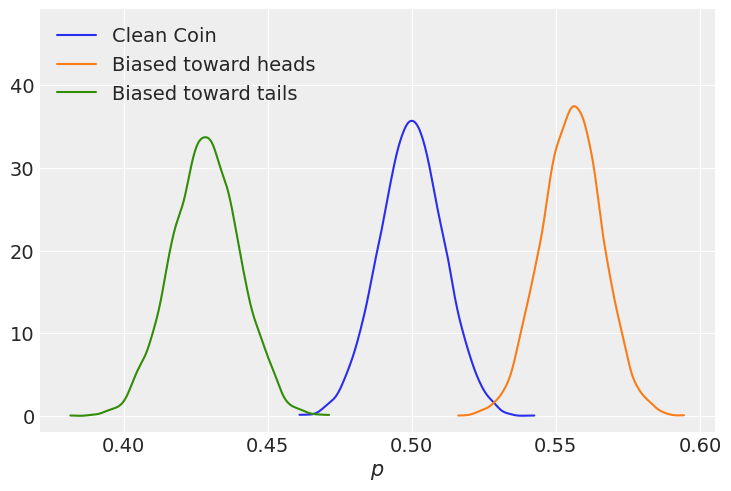

In [7]:
effect_per_micron = 5.0

# Clean Coin
alpha = 1_000
beta = 1_000
p = np.random.beta(alpha, beta, size=10_000)

# Add two std to tails side (heads more likely)
p_heads = np.random.beta(alpha + 50 * effect_per_micron, beta, size=10_000)
# Add two std to heads side (tails more likely)
p_tails = np.random.beta(alpha - 50 * effect_per_micron, beta, size=10_000)

az.plot_kde(p, label="Clean Coin")
az.plot_kde(p_heads, label="Biased toward heads", plot_kwargs={"color":"C1"})
az.plot_kde(p_tails, label="Biased toward tails", plot_kwargs={"color":"C2"})
plt.xlabel("$p$")
plt.ylim(top=plt.ylim()[1]*1.25);

Next, we'll generate a toy dataset according to our specifications above. As an added foil, we will also assume that we're limited in our measuring equipment, that we can only measure correctly to the nearest integer micron.

In [8]:
# Create amount of dirt on top and bottom
heads_bias_dirt = stats.halfnorm(loc=0, scale=25).rvs(size=1_000)
tails_bias_dirt = stats.halfnorm(loc=0, scale=25).rvs(size=1_000)

# Create the probability per coin
alpha = np.repeat(1_000, 1_000)
alpha = alpha + effect_per_micron * heads_bias_dirt - effect_per_micron * tails_bias_dirt
beta = np.repeat(1_000, 1_000)

p = np.random.beta(alpha, beta)

df = pd.DataFrame({
    "p" : p,
    "heads_bias_dirt" : heads_bias_dirt.round(),
    "tails_bias_dirt" : tails_bias_dirt.round()
})
df.head()

,p,heads_bias_dirt,tails_bias_dirt
0,0.531709,31.0,1.0
1,0.506383,19.0,4.0
2,0.534763,28.0,10.0
3,0.518712,32.0,7.0
4,0.514520,22.0,22.0


Taking a look at our new dataset:

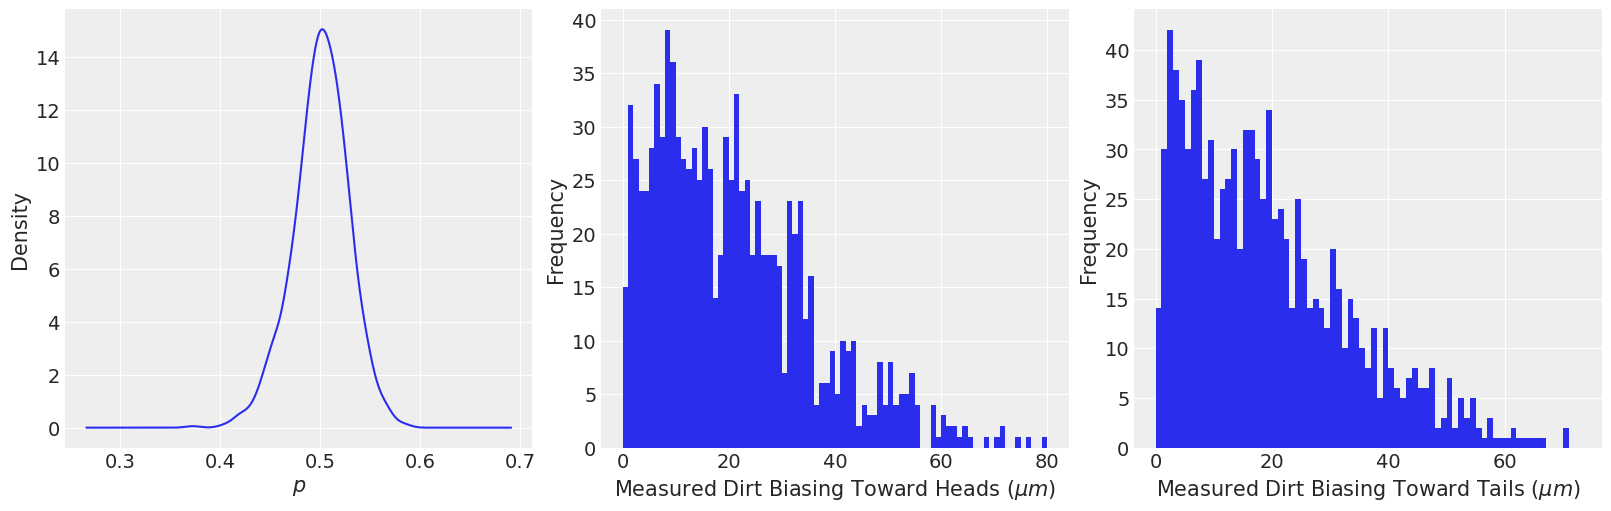

In [9]:
fig,ax = plt.subplots(1,3, figsize=(16,5))

df["p"].plot.kde(ax=ax[0])
ax[0].set_xlabel("$p$")

df["heads_bias_dirt"].plot.hist(ax=ax[1], bins=np.arange(0,df["heads_bias_dirt"].max()))
ax[1].set_xlabel("Measured Dirt Biasing Toward Heads ($\mu m$)")
df["tails_bias_dirt"].plot.hist(ax=ax[2], bins=np.arange(0,df["tails_bias_dirt"].max()))
ax[2].set_xlabel("Measured Dirt Biasing Toward Tails ($\mu m$)");

Next we want to make a model to recover the effect per micron of dirt per side. So far, we've considered the biasing toward one side or another independently. A linear model might look something like this:

$$
\begin{aligned}
p &\sim \text{Beta}(\mu, \sigma) \\
\text{logit}(\mu) &= \text{ Normal}( \alpha + \beta_h d_h + \beta_t d_t)
\end{aligned}
$$

Where $d_h$ and $d_t$ are the measured dirt (in microns) biasing the probability toward heads and tails respectively, $\beta_h$ and $\beta_t$ are coefficients for how much a micron of dirt affects each independent side, and $\alpha$ is the intercept. Also note the logit link function used here, since our outcome is on the scale of 0-1, it makes sense that the link must also put our mean on that scale. Logit is the default link function, however Bambi supports the identity, probit, and cloglog links as well. 

In this toy example, we've constructed it such that dirt should not affect one side differently from another, so we can wrap those into one coefficient: $\beta = \beta_h = -\beta_t$. This makes the last line of the model:

$$
\text{logit}(\mu) = \text{ Normal}( \alpha + \beta \Delta d)
$$

where $\Delta d = d_h - d_t$.

Putting that into our dataset, then constructing this model in Bambi,

In [10]:
df["delta_d"] = df["heads_bias_dirt"] - df["tails_bias_dirt"]
dirt_model = bmb.Model("p ~ delta_d", df, family="beta")
dirt_fitted = dirt_model.fit()
dirt_model.predict(dirt_fitted, kind="response")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, Intercept, delta_d]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [11]:
az.summary(dirt_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kappa,1883.411,87.610,1721.713,2049.028,1.226,1.385,5317.0,3004.0,1.0
Intercept,-0.004,0.001,-0.007,-0.002,0.000,0.000,5112.0,3124.0,1.0
delta_d,0.005,0.000,0.005,0.005,0.000,0.000,5864.0,2968.0,1.0
mu[0],0.536,0.001,0.535,0.537,0.000,0.000,5813.0,3222.0,1.0
mu[1],0.517,0.000,0.517,0.518,0.000,0.000,5504.0,3233.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[995],0.494,0.000,0.493,0.495,0.000,0.000,5089.0,2869.0,1.0
mu[996],0.444,0.001,0.442,0.446,0.000,0.000,5543.0,3158.0,1.0
mu[997],0.468,0.001,0.467,0.469,0.000,0.000,5345.0,3322.0,1.0
mu[998],0.500,0.000,0.499,0.501,0.000,0.000,5129.0,3198.0,1.0


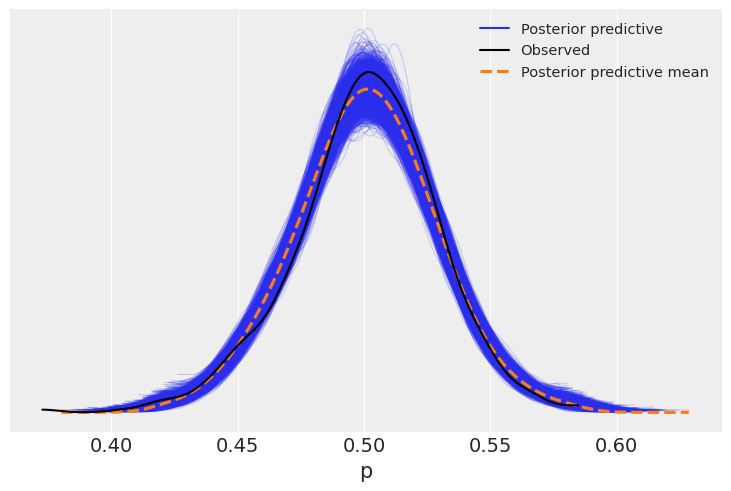

In [12]:
az.plot_ppc(dirt_fitted);

Next, we'll see if we can in fact recover the effect on $\alpha$. Remember that in order to return to $\alpha$, $\beta$ space, the linear equation passes through an inverse logit transformation, so we must apply this to the coefficient on $\Delta d$ to get the effect on $\alpha$. The inverse logit is nicely defined in `scipy.special` as `expit`.

In [13]:
mean_effect = expit(dirt_fitted.posterior.delta_d.mean())
hdi = az.hdi(dirt_fitted.posterior.delta_d, hdi_prob=.95)
lower = expit(hdi.delta_d[0])
upper = expit(hdi.delta_d[1])
print(f"Mean effect: {mean_effect.item():.4f}")
print(f"95% interval {lower.item():.4f} - {upper.item():.4f}")

Mean effect: 0.5012
95% interval 0.5012 - 0.5013


The recovered effect is very close to the true effect of 0.5.

## Example - Revisiting Baseball Data

In the [Hierarchical Logistic regression with Binomial family](https://bambinos.github.io/bambi/notebooks/hierarchical_binomial_bambi.html) notebook, we modeled baseball batting averages (times a player reached first via a hit per times at bat) via a Hierarchical Logisitic regression model. If we're interested in league-wide effects, we could look at a Beta regression. We work off the assumption that the league-wide batting average follows a Beta distribution, and that individual player's batting averages are samples from that distribution.

First, load the Batting dataset again, and re-calculate batting average as hits/at-bat. In order to make sure that we have a sufficient sample, we'll require at least 100 at-bats in order consider a batter. Last, we'll focus on 1990-2018.

In [14]:
batting = bmb.load_data("batting")

In [15]:
batting["batting_avg"] = batting["H"] / batting["AB"]
batting = batting[batting["AB"] > 100]
df = batting[ (batting["yearID"] > 1990) & (batting["yearID"] < 2018) ]

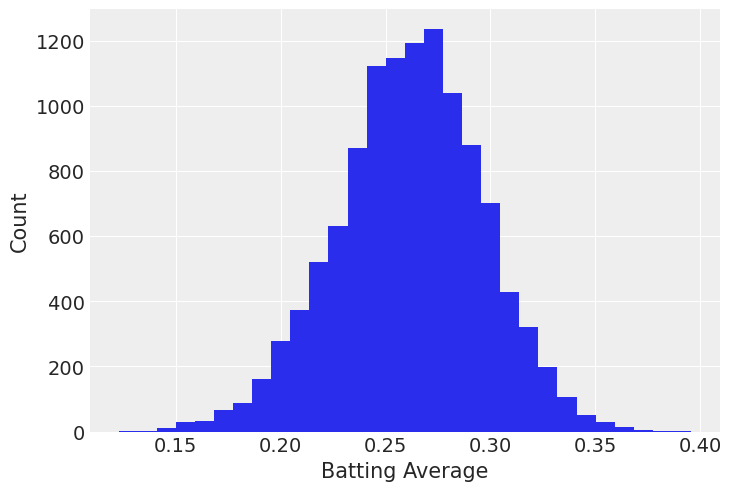

In [16]:
df.batting_avg.hist(bins=30)
plt.xlabel("Batting Average")
plt.ylabel("Count");

If we're interested in modeling the distribution of batting averages, we can start with an intercept-only model.

In [17]:
model_avg = bmb.Model("batting_avg ~ 1", df, family="beta")
avg_fitted = model_avg.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, Intercept]


Output()

/home/tomas/oss/bambinos/bambi/.pixi/envs/dev/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [18]:
az.summary(avg_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kappa,152.549,2.008,148.842,156.278,0.032,0.033,3829.0,2558.0,1.0
Intercept,-1.038,0.002,-1.041,-1.035,0.000,0.000,4094.0,3088.0,1.0


Looking at the posterior predictive,

In [19]:
posterior_predictive = model_avg.predict(avg_fitted, kind="response")

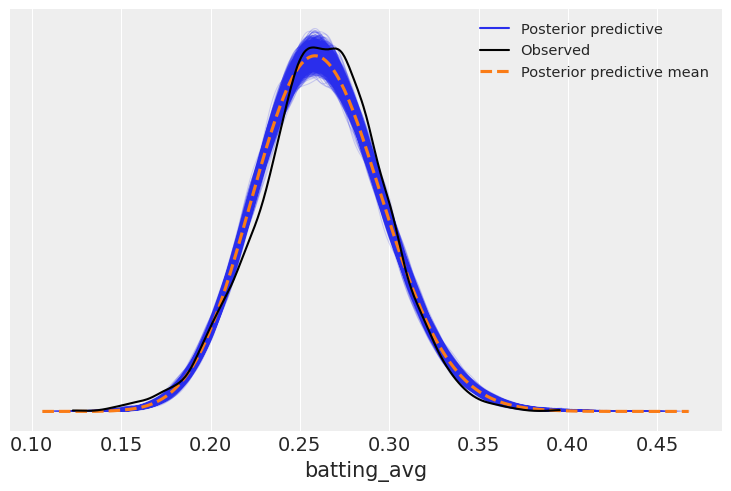

In [20]:
az.plot_ppc(avg_fitted);

This appears to fit reasonably well. If, for example, we were interested in simulating players, we could sample from this distribution.

However, we can take this further. Say we're interested in understanding how this distribution shifts if we know a player's batting average in a previous year. We can condition the model on a player's n-1 year, and use Beta regrssion to model that. Let's construct that variable, and for sake of ease, we will ignore players without previous seasons.

In [21]:
# Add the player's batting average in the n-1 year
batting["batting_avg_shift"] = np.where(
    batting["playerID"] == batting["playerID"].shift(),
    batting["batting_avg"].shift(),
    np.nan
)
df_shift = batting[ (batting["yearID"] > 1990) & (batting["yearID"] < 2018) ]
df_shift = df_shift[~df_shift["batting_avg_shift"].isna()]
df_shift[["batting_avg_shift","batting_avg"]].corr()

,batting_avg_shift,batting_avg
batting_avg_shift,1.000000,0.229774
batting_avg,0.229774,1.000000


 There is a lot of variance in year-to-year batting averages, it's not known to be incredibly predictive, and we see that here. A correlation coefficient of 0.23 is only lightly predictive. However, we can still use it in our model to get a better understanding. We'll fit two models. First, we'll refit the previous, intercept-only, model using this updated dataset so we have an apples-to-apples comparison. Then, we'll fit a model using the previous year's batting average as a predictor.

 Notice we need to explicitly ask for the inclusion of the log-likelihood values into the inference data object.

In [22]:
model_avg = bmb.Model("batting_avg ~ 1", df_shift, family="beta")
avg_fitted = model_avg.fit(idata_kwargs={"log_likelihood": True})

model_lag = bmb.Model("batting_avg ~ batting_avg_shift", df_shift, family="beta")
lag_fitted = model_lag.fit(idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, Intercept]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, Intercept, batting_avg_shift]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took -0 seconds.


In [23]:
az.summary(lag_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kappa,135.929,9.136,119.172,153.969,0.118,0.147,5942.0,3036.0,1.0
Intercept,-1.377,0.071,-1.506,-1.245,0.001,0.001,5823.0,3111.0,1.0
batting_avg_shift,1.356,0.272,0.867,1.858,0.004,0.004,5800.0,3105.0,1.0


In [24]:
az.compare({
    "intercept-only" : avg_fitted,
    "lag-model": lag_fitted
})

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
lag-model,0,785.079800,2.948934,0.000000,0.99884,14.543180,0.000000,False,log
intercept-only,1,774.133237,2.098372,10.946563,0.00116,15.329343,4.648853,False,log


Adding the predictor results in a higher loo than the intercept-only model.

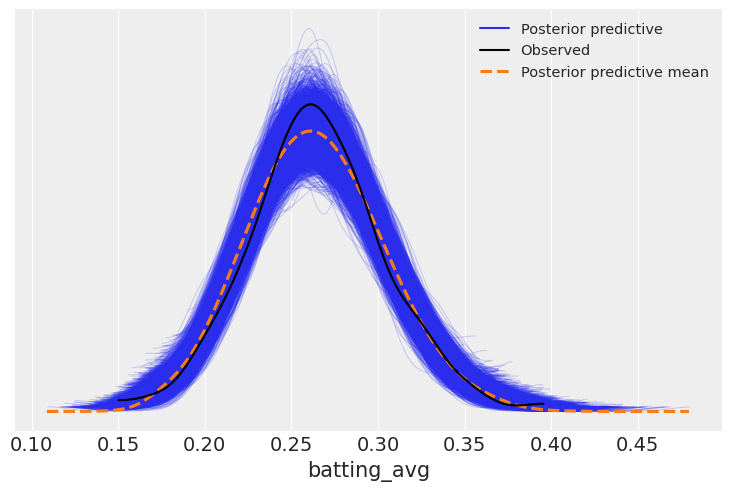

In [25]:
ppc= model_lag.predict(lag_fitted, kind="response")
az.plot_ppc(lag_fitted);

The biggest question this helps us understand is, for each point of batting average in the previous year, how much better do we expect a player to be in the current year?

In [26]:
mean_effect = lag_fitted.posterior.batting_avg_shift.mean().item()
hdi = az.hdi(lag_fitted.posterior.batting_avg_shift, hdi_prob=.95)

lower = expit(hdi.batting_avg_shift[0]).item()
upper = expit(hdi.batting_avg_shift[1]).item()
print(f"Mean effect: {expit(mean_effect):.4f}")
print(f"95% interval {lower:.4f} - {upper:.4f}")

Mean effect: 0.7950
95% interval 0.6950 - 0.8651


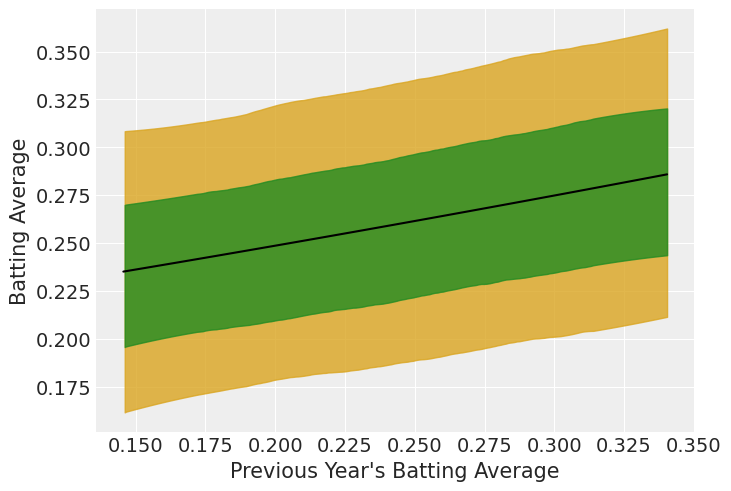

In [27]:
az.plot_hdi(df_shift.batting_avg_shift, lag_fitted.posterior_predictive.batting_avg, hdi_prob=0.95, color="goldenrod", fill_kwargs={"alpha":0.8})
az.plot_hdi(df_shift.batting_avg_shift, lag_fitted.posterior_predictive.batting_avg, hdi_prob=.68, color="forestgreen", fill_kwargs={"alpha":0.8})

intercept = lag_fitted.posterior.Intercept.values.mean()
x = np.linspace(df_shift.batting_avg_shift.min(), df_shift.batting_avg_shift.max(),100)
linear = mean_effect * x + intercept
plt.plot(x, expit(linear), c="black")
plt.xlabel("Previous Year's Batting Average")
plt.ylabel("Batting Average");

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Sep 28 2025

Python implementation: CPython
Python version       : 3.13.7
IPython version      : 9.4.0

arviz     : 0.22.0
scipy     : 1.16.2
numpy     : 2.3.3
pandas    : 2.3.2
bambi     : 0.14.1.dev56+gd93591cd2.d20250927
matplotlib: 3.10.6

Watermark: 2.5.0

